In [5]:
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from  sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import pprint
%matplotlib inline


class KNN:
    def __init__(self, train_features, train_labels):
        self.train_features = train_features
        self.train_labels = train_labels

    def get_distances(self, query_features):
        diff = query_features - self.train_features
        distances = np.sqrt(np.sum(diff ** 2, axis=1))
        return distances

    def get_k_nearest_neighbours(self, k, query_features):
        distances = self.get_distances(query_features)
        neighbours = np.argsort(distances)[0:k]
        return neighbours

    def predict(self, k, query_features):
        neighbours = self.get_k_nearest_neighbours(k, query_features)
        y_predictions = self.train_labels[neighbours]
        counter = Counter(y_predictions)
        y_predict = counter.most_common(1)[0][0]
        return y_predict


def z_normalize(features):
    return (features - np.mean(features, axis=0)) / np.std(features, axis=0)


def get_accuracy(test_labels, predictions):
    correct_results = np.sum(np.isclose(test_labels, predictions))
    return correct_results / float(len(test_labels))


def get_data(filename):
    data = np.loadtxt(filename, delimiter=',')
    print "Reading data from [{}] with Shape:{}".format(filename, data.shape)
    return data


def k_fold_generator(X, y, k_fold):
    subset_size = (X.shape[0]) / k_fold
    for k in range(1, k_fold + 1):
        start_valid = (k - 1) * subset_size
        end_valid = start_valid + subset_size
        valid_rows = np.arange(start_valid, end_valid)
        train_rows = [x for x in range(X.shape[0]) if x not in valid_rows]
        X_train = X[train_rows, :]
        X_valid = X[valid_rows, :]
        y_train = y[train_rows]
        y_valid = y[valid_rows]
        yield X_train, y_train, X_valid, y_valid


def part_a():
    train_features = get_data("spambase/spambase_train.txt")
    train_labels = get_data("spambase/spambase_train_label.txt")
    test_features = get_data("spambase/spambase_test.txt")
    test_labels = get_data("spambase/spambase_test_label.txt")

    knn = KNN(train_features=train_features, train_labels=train_labels)

    k_values = [1, 5, 21, 41, 61, 81, 101, 201, 401]
    accuracy = []
    accuracy_skl = []
    for k in k_values:
        predictions = []
        predictions_skl = []
        for i in range(len(test_features)):
            predictions.append(knn.predict(k, test_features[i]))
            neigh = KNeighborsClassifier(n_neighbors=k)
            neigh.fit(train_features, train_labels)
            predictions_skl.append(neigh.predict(test_features[i].reshape(1, -1)))
        # print predictions
        # print test_labels
        accuracy.append(get_accuracy(test_labels, predictions))
        accuracy_skl.append(accuracy_score(test_labels, predictions_skl))
        # accuracy.append(accuracy_score(test_labels, predictions))
    print accuracy
    print accuracy_skl

    fig, ax = plt.subplots(2)
    fig.set_size_inches(6, 8)
    ax[0].plot(k_values, accuracy, 'bo-')
    ax[0].set_ylabel("accuracy")
    ax[0].set_xlabel("k")
    ax[0].set_title("KNN: k vs. accuracy")

    ax[1].plot(k_values, accuracy_skl, 'ro-')
    ax[1].set_ylabel("accuracy")
    ax[1].set_xlabel("k")
    ax[1].set_title("KNN with sklearn: k vs. accuracy")


def part_b():
    train_features = get_data("spambase/spambase_train.txt")
    train_labels = get_data("spambase/spambase_train_label.txt")
    test_features = get_data("spambase/spambase_test.txt")
    test_labels = get_data("spambase/spambase_test_label.txt")

    # print train_features[0]
    # print test_features[0]

    # Normalize
    train_features = z_normalize(train_features)
    test_features = z_normalize(test_features)

    # print train_features[0]
    # print test_features[0]

    knn = KNN(train_features=train_features, train_labels=train_labels)

    k_values = [1, 5, 21, 41, 61, 81, 101, 201, 401]
    accuracy = []
    for k in k_values:
        predictions = []
        for i in range(len(test_features)):
            predictions.append(knn.predict(k, test_features[i]))
        accuracy.append(get_accuracy(test_labels, predictions))
    print accuracy

    fig, ax = plt.subplots(1)
    # fig.set_size_inches(6, 8)
    ax.plot(k_values, accuracy, 'bo-')
    ax.set_ylabel("accuracy")
    ax.set_xlabel("k")
    ax.set_title("KNN: k vs. accuracy")


def part_c():
    train_features = get_data("spambase/spambase_train.txt")
    train_labels = get_data("spambase/spambase_train_label.txt")
    test_features = get_data("spambase/spambase_test.txt")
    test_labels = get_data("spambase/spambase_test_label.txt")

    # Normalize
    train_features = z_normalize(train_features)
    test_features = z_normalize(test_features)

    knn = KNN(train_features=train_features, train_labels=train_labels)
    k_values = [1, 5, 21, 41, 61, 81, 101, 201, 401]
    result = {}
    for i in range(50):
        predictions = []
        for k in k_values:
            predictions.append(knn.predict(k, test_features[i]))
        result[i + 1] = map(lambda x: "spam" if x == 1.0 else "no", predictions)
    pprint.pprint(result, width=150)


def part_d():
    train_features = get_data("spambase/spambase_train.txt")
    train_labels = get_data("spambase/spambase_train_label.txt")
    train_features = z_normalize(train_features)

    k_fold = 5
    cv = []
    for X_train, y_train, X_valid, y_valid in k_fold_generator(train_features, train_labels, k_fold):
        knn = KNN(train_features=X_train, train_labels=y_train)
        accuracy = []
        for k in range(1, 150):
            predictions = []
            for i in range(len(X_valid)):
                predictions.append(knn.predict(k, X_valid[i]))
            accuracy.append(get_accuracy(y_valid, predictions))
        cv.append(accuracy)
    accuracy_on_k = np.mean(np.array(cv), axis=0)
    optimal_k_index = np.argmax(accuracy_on_k)
    print "Optimal Value for K is [{}] with Accuracy [{}]".format(optimal_k_index+1,accuracy_on_k[optimal_k_index])

Reading data from [spambase/spambase_train.txt] with Shape:(2300, 57)
Reading data from [spambase/spambase_train_label.txt] with Shape:(2300,)
Reading data from [spambase/spambase_test.txt] with Shape:(2301, 57)
Reading data from [spambase/spambase_test_label.txt] with Shape:(2301,)
[0.75184702303346373, 0.75488917861799221, 0.74663189917427208, 0.75228161668839633, 0.73750543242068667, 0.72664059104737067, 0.72881355932203384, 0.73142112125162972, 0.71968709256844854]
[0.75184702303346373, 0.75488917861799221, 0.74619730551933938, 0.75228161668839633, 0.73750543242068667, 0.72664059104737067, 0.72881355932203384, 0.73142112125162972, 0.71968709256844854]


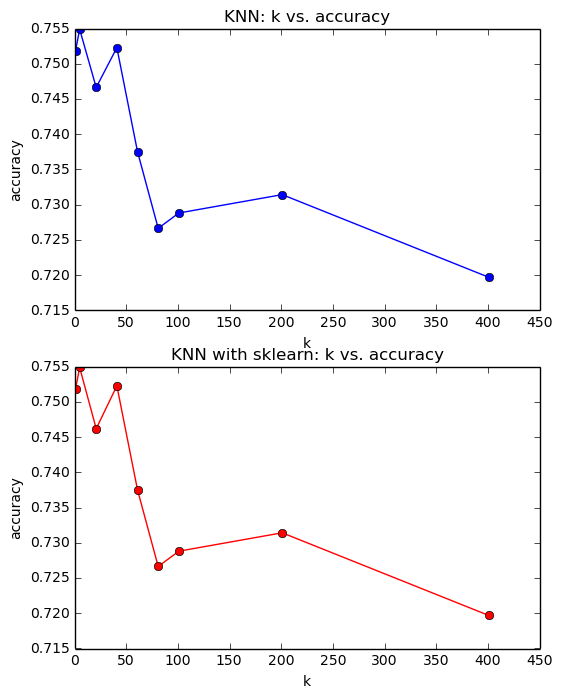

In [6]:
part_a()

Reading data from [spambase/spambase_train.txt] with Shape:(2300, 57)
Reading data from [spambase/spambase_train_label.txt] with Shape:(2300,)
Reading data from [spambase/spambase_test.txt] with Shape:(2301, 57)
Reading data from [spambase/spambase_test_label.txt] with Shape:(2301,)
[0.82312038244241637, 0.83224684919600178, 0.87092568448500651, 0.87049109083007392, 0.87005649717514122, 0.86962190352020863, 0.86397218600608428, 0.84615384615384615, 0.81442850934376354]


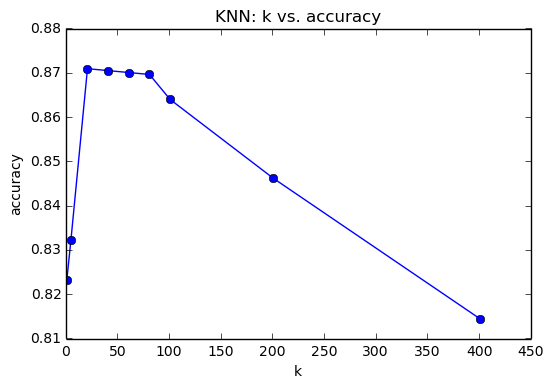

In [7]:
part_b()

In [8]:
part_c()

Reading data from [spambase/spambase_train.txt] with Shape:(2300, 57)
Reading data from [spambase/spambase_train_label.txt] with Shape:(2300,)
Reading data from [spambase/spambase_test.txt] with Shape:(2301, 57)
Reading data from [spambase/spambase_test_label.txt] with Shape:(2301,)
{1: ['spam', 'spam', 'spam', 'spam', 'no', 'no', 'no', 'no', 'no'],
 2: ['spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'no', 'no', 'no'],
 3: ['spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam'],
 4: ['spam', 'spam', 'spam', 'no', 'no', 'spam', 'spam', 'spam', 'spam'],
 5: ['spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam'],
 6: ['spam', 'spam', 'no', 'no', 'spam', 'spam', 'spam', 'spam', 'spam'],
 7: ['spam', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no'],
 8: ['spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam'],
 9: ['spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam'],
 10: ['spam', 'spam', 'spam', 'spam', 'spam', 'spam', 

In [9]:
part_d()

Reading data from [spambase/spambase_train.txt] with Shape:(2300, 57)
Reading data from [spambase/spambase_train_label.txt] with Shape:(2300,)
Optimal Value for K is [5] with Accuracy [0.837826086957]
